In [ ]:
%pip install audiomentations

In [2]:
import pandas as pd
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier # A good general-purpose choice
# from sklearn.linear_model import LogisticRegression # A simpler choice
# from sklearn.svm import SVC # Another option
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [ ]:


# Suppress specific warnings from librosa for cleaner output
warnings.filterwarnings("ignore", category=UserWarning, module='librosa')
warnings.filterwarnings("ignore", category=FutureWarning, module='librosa')

# --- Configuration ---
BASE_DATA_PATH = r"C:\Users\mouni\Downloads\cv-corpus-21.0-delta-2025-03-14-en\cv-corpus-21.0-delta-2025-03-14\en"
# Use 'validated.tsv' if available and preferred, as it usually has more checks.
# If you only have 'other.tsv' with accent info, use that.
# Other common files: train.tsv, dev.tsv, test.tsv
TSV_FILE = os.path.join(BASE_DATA_PATH, "other.tsv") # <--- CHANGE THIS if using other.tsv or similar
CLIPS_DIR = os.path.join(BASE_DATA_PATH, "clips")

# 1. Define how to map raw accent strings from TSV to cleaner labels
#    Update this based on the unique values in YOUR 'accents' column
ACCENT_MAP = {
    "United States English": "US",
    "England English": "UK",
    "Scottish English": "Scotland",
    "Australian English": "Australia",
    "Canadian English": "Canada",
    "Indian English": "India",
    "Irish English": "Ireland",
    "Welsh English": "Wales",
    "New Zealand English": "NewZealand",
    "South African English": "SouthAfrica"
    # Add more mappings as you discover them in your TSV's 'accents' column
    # e.g., "us" : "US", "gb": "UK" if you see shorthand
}

# 2. Select WHICH of the mapped accents you want to include in this model
#    Start with 2 or 3 distinct accents for faster iteration.
SELECTED_ACCENTS_FOR_MODEL = ["US", "UK", "Australia"] # Example

# Audio parameters
SAMPLE_RATE = 16000  # Hz, common for speech
DURATION = 5         # seconds, fixed length for audio segments
N_MFCC = 20          # Number of MFCCs to extract (13-20 is common)
MAX_FILES_PER_ACCENT = 200 # Limit files per accent for quicker testing, set to None for all

# --- Helper Functions ---

def load_and_preprocess_audio(file_path, target_sr=SAMPLE_RATE, fixed_duration=DURATION):
    """Loads, resamples, and pads/truncates audio to a fixed length."""
    try:
        # Load audio file
        # Librosa automatically resamples if `sr` is different from the file's original sr
        y, sr = librosa.load(file_path, sr=target_sr, mono=True)

        target_length = int(fixed_duration * target_sr)

        # Pad if too short
        if len(y) < target_length:
            y = np.pad(y, (0, target_length - len(y)), 'constant')
        # Truncate if too long
        elif len(y) > target_length:
            y = y[:target_length]
        return y
    except Exception as e:
        print(f"Error loading or processing {file_path}: {e}")
        return None

def extract_features(audio_segment, sr=SAMPLE_RATE, n_mfcc=N_MFCC):
    """Extracts MFCCs and returns their mean over time."""
    if audio_segment is None:
        return None
    try:
        mfccs = librosa.feature.mfcc(y=audio_segment, sr=sr, n_mfcc=n_mfcc)
        mfccs_processed = np.mean(mfccs.T, axis=0) # Take the mean of MFCCs over time
        return mfccs_processed
    except Exception as e:
        print(f"Error extracting features: {e}")
        return None

# --- Main Script ---

# 1. Load and Prepare Metadata
print(f"Loading metadata from: {TSV_FILE}")
try:
    df = pd.read_csv(TSV_FILE, sep='\t', usecols=['client_id', 'path', 'sentence', 'accents'])
except FileNotFoundError:
    print(f"ERROR: TSV file not found at {TSV_FILE}. Please check the path.")
    exit()
except Exception as e:
    print(f"Error reading TSV file: {e}")
    exit()

print(f"Original dataframe shape: {df.shape}")
df.dropna(subset=['accents'], inplace=True) # Remove rows where accent is not specified
print(f"Shape after dropping NA accents: {df.shape}")

# Apply the mapping to standardize accent labels
df['mapped_accent'] = df['accents'].apply(lambda x: ACCENT_MAP.get(str(x).split(',')[0].strip(), "Other")) # Takes the first accent if multiple are listed

# Filter for only the accents we want to model
df_filtered = df[df['mapped_accent'].isin(SELECTED_ACCENTS_FOR_MODEL)].copy() # Use .copy() to avoid SettingWithCopyWarning
print(f"Shape after filtering for selected accents ({SELECTED_ACCENTS_FOR_MODEL}): {df_filtered.shape}")

if df_filtered.empty:
    print("No data remaining after filtering for selected accents. Check your ACCENT_MAP and SELECTED_ACCENTS_FOR_MODEL.")
    print("Available unique 'accents' values in your TSV (first 20):")
    print(df['accents'].value_counts().head(20))
    print("\nAvailable unique 'mapped_accent' values after trying to map (first 20):")
    print(df['mapped_accent'].value_counts().head(20))
    exit()

# Optional: Balance dataset by limiting files per accent (for faster initial runs)
if MAX_FILES_PER_ACCENT is not None:
    df_balanced = df_filtered.groupby('mapped_accent').sample(n=min(MAX_FILES_PER_ACCENT, df_filtered['mapped_accent'].value_counts().min()), random_state=42, replace=False)
    print(f"Shape after balancing (max {MAX_FILES_PER_ACCENT} per accent or min class count): {df_balanced.shape}")
else:
    df_balanced = df_filtered

if df_balanced.empty:
    print("No data remaining after balancing. This might happen if MAX_FILES_PER_ACCENT is too small or classes are very imbalanced.")
    exit()

print("\nAccent distribution in the data to be processed:")
print(df_balanced['mapped_accent'].value_counts())



Loading metadata from: C:\Users\mouni\Downloads\cv-corpus-21.0-delta-2025-03-14-en\cv-corpus-21.0-delta-2025-03-14\en\other.tsv
Original dataframe shape: (21499, 4)
Shape after dropping NA accents: (13766, 4)
Shape after filtering for selected accents (['US', 'UK', 'Australia']): (4649, 5)
Shape after balancing (max 300 per accent or min class count): (603, 5)

Accent distribution in the data to be processed:
mapped_accent
Australia    201
UK           201
US           201
Name: count, dtype: int64


In [19]:
# 2. Feature Extraction
features = []
labels = []
valid_paths_count = 0
print("\nStarting feature extraction...")
for index, row in df_balanced.iterrows():
    file_name = row['path']
    accent_label = row['mapped_accent']
    full_file_path = os.path.join(CLIPS_DIR, file_name)

    if not os.path.exists(full_file_path):
        # print(f"Warning: File not found - {full_file_path}")
        continue
    valid_paths_count += 1

    audio_data = load_and_preprocess_audio(full_file_path)
    if audio_data is not None:
        mfcc_features = extract_features(audio_data)
        if mfcc_features is not None:
            features.append(mfcc_features)
            labels.append(accent_label)

    if (index + 1) % 100 == 0:
        print(f"Processed {index + 1}/{len(df_balanced)} files...")

print(f"Finished feature extraction. Found {valid_paths_count} valid file paths.")
print(f"Successfully extracted features for {len(features)} samples.")

if not features:
    print("No features were extracted. Please check audio paths, file formats, and potential errors during loading/feature extraction.")
    exit()

X = np.array(features)
y_labels = np.array(labels)

# 3. Encode Labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_labels)
print("\nLabel mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{class_name}: {i}")

# 4. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# 5. Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining data shape: {X_train_scaled.shape}")
print(f"Test data shape: {X_test_scaled.shape}")


Starting feature extraction...
Processed 16700/600 files...
Processed 11800/600 files...
Processed 9900/600 files...
Finished feature extraction. Found 600 valid file paths.
Successfully extracted features for 600 samples.

Label mapping:
Australia: 0
UK: 1
US: 2

Training data shape: (480, 20)
Test data shape: (120, 20)


In [20]:
# 6. Train Model
# model = LogisticRegression(random_state=42, max_iter=1000, C=0.1) # C is inverse of regularization strength
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced') # class_weight='balanced' can help with imbalanced data
# model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, class_weight='balanced') # SVC can be powerful but slower

print(f"\nTraining a {model.__class__.__name__} model...")
model.fit(X_train_scaled, y_train)
print("Model training complete.")


Training a RandomForestClassifier model...
Model training complete.



Accuracy: 84.17%

Classification Report:
              precision    recall  f1-score   support

   Australia       0.95      0.88      0.91        40
          UK       0.81      0.88      0.84        40
          US       0.78      0.78      0.78        40

    accuracy                           0.84       120
   macro avg       0.84      0.84      0.84       120
weighted avg       0.84      0.84      0.84       120


Confusion Matrix:


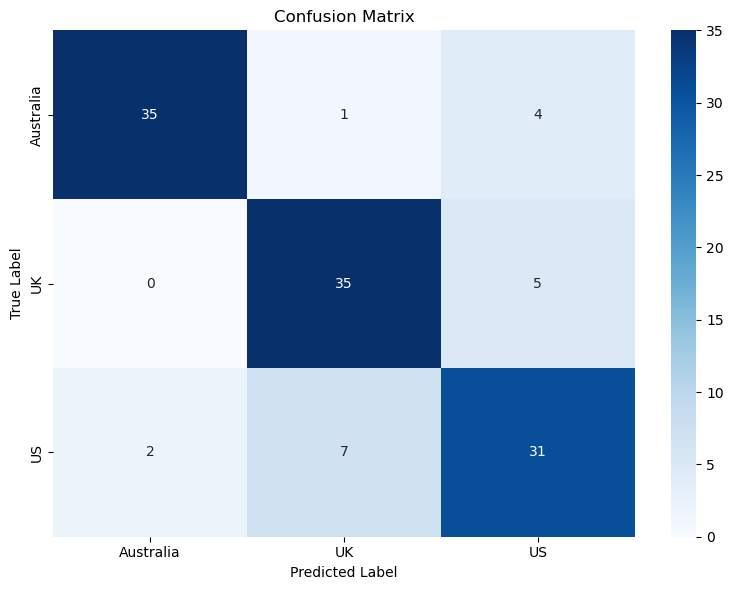


--- Script Finished ---


In [21]:
# 7. Evaluate Model
y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

print("\nClassification Report:")
# Use target_names for readable report
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=0)
print(report)

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print("\n--- Script Finished ---")

In [15]:
# In your training script, before saving label_encoder
print("LabelEncoder classes:", label_encoder.classes_)
print("LabelEncoder type:", type(label_encoder))

LabelEncoder classes: ['Australia' 'UK' 'US']
LabelEncoder type: <class 'sklearn.preprocessing._label.LabelEncoder'>


Base data path: C:\Users\mouni\Downloads\cv-corpus-21.0-delta-2025-03-14\en
Looking for file: C:\Users\mouni\Downloads\cv-corpus-21.0-delta-2025-03-14\en\other.tsv
Successfully loaded: other.tsv
Looking for file: C:\Users\mouni\Downloads\cv-corpus-21.0-delta-2025-03-14\en\validated.tsv
Successfully loaded: validated.tsv
Shape after balancing base files (target 200 per accent): (600, 5)

Base accent distribution:
mapped_accent
Australia    200
UK           200
US           200
Name: count, dtype: int64
Train samples: 420, Val samples: 90, Test samples: 90

Processing train data...


C:\Users\mouni\AppData\Local\Temp\ipykernel_15928\1852706362.py:124: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df_filtered.groupby('mapped_accent', group_keys=False).apply(


Processed 50/600 total base files...
Processed 100/600 total base files...
Processed 150/600 total base files...
Processed 200/600 total base files...
Processed 250/600 total base files...
Processed 300/600 total base files...
Processed 350/600 total base files...
Processed 400/600 total base files...

Processing val data...
Processed 450/600 total base files...
Processed 500/600 total base files...

Processing test data...
Processed 550/600 total base files...
Processed 600/600 total base files...

Feature extraction complete.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 157, 60)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 157, 64)   │     19,264 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 157, 64)   │        256 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 78, 64)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 78, 64)    │          0 │ max_pooling1d_6[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 78, 128)   │     41,088 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 78, 128)   │        512 │ conv1d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 39, 128)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 39, 128)   │          0 │ max_pooling1d_7[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ (None, 39, 256)   │    263,168 │ dropout_16[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 39, 256)   │    526,080 │ bidirectional_6[… │
│ (MultiHeadAttentio… │                   │            │ bidirectional_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 39, 256)   │        512 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_7     │ (None, 256)       │    394,240 │ layer_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ bidirectional_7[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │     16,448 │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 64)        │          0 │ batch_normalizat

 Total params: 1,263,043 (4.82 MB)

 Trainable params: 1,262,019 (4.81 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 203ms/step - accuracy: 0.4578 - loss: 1.5767 - val_accuracy: 0.3667 - val_loss: 1.2221 - learning_rate: 0.0010
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.6083 - loss: 1.2695 - val_accuracy: 0.3444 - val_loss: 1.4383 - learning_rate: 0.0010
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.6941 - loss: 0.9663 - val_accuracy: 0.6000 - val_loss: 1.0596 - learning_rate: 0.0010
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.6945 - loss: 0.8465 - val_accuracy: 0.6000 - val_loss: 0.9428 - learning_rate: 0.0010
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.7310 - loss: 0.8465 - val_accuracy: 0.5556 - val_loss: 1.1141 - learning_rate: 0.0010
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.8296 - loss: 0.6623 - val_accuracy: 0.6556 - val_loss: 0.8518 - learning_rate: 0.0010
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.8276 - loss: 0

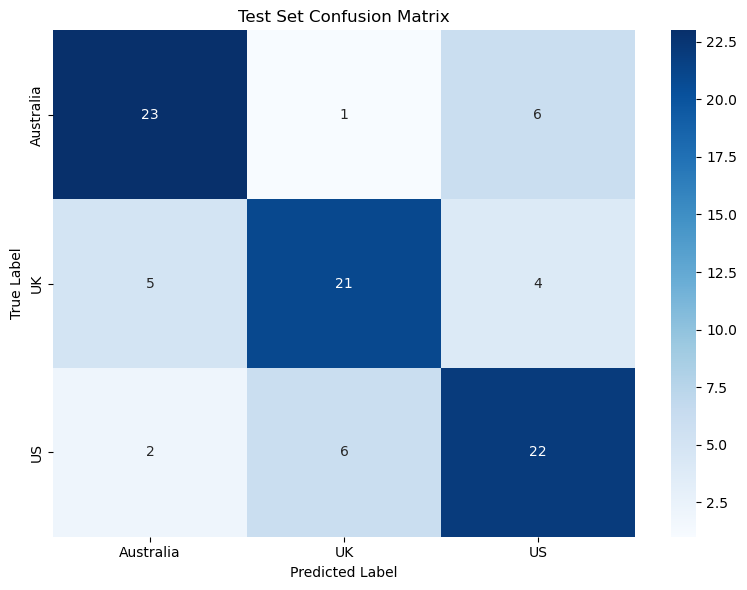

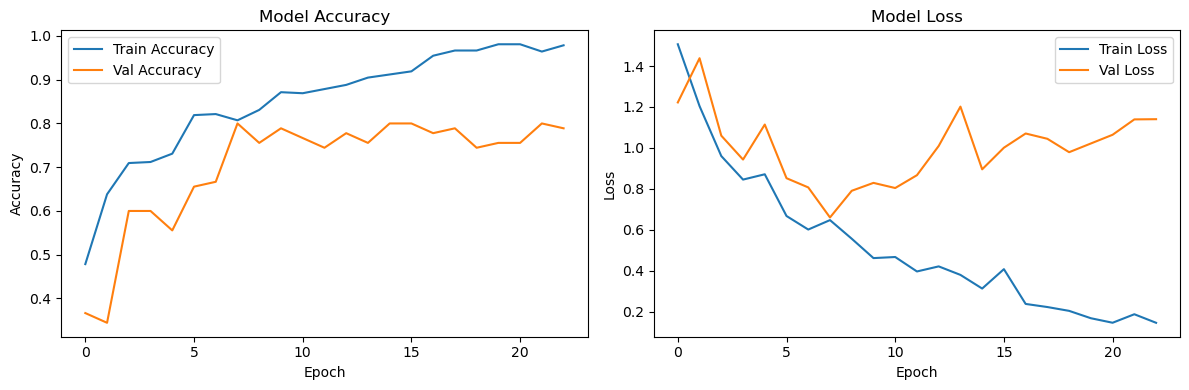

In [6]:
import pandas as pd
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Dropout, BatchNormalization, MultiHeadAttention, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, Gain

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, module='librosa')
warnings.filterwarnings("ignore", category=FutureWarning, module='librosa')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

# Configuration
BASE_DATA_PATH = r"C:\Users\mouni\Downloads\cv-corpus-21.0-delta-2025-03-14\en"

CLIPS_DIR = os.path.join(BASE_DATA_PATH, "clips")
TSV_FILES_TO_LOAD = ["other.tsv", "validated.tsv"]
USE_COLUMNS = ['client_id', 'path', 'sentence', 'accents']

ACCENT_MAP = {
    "United States English": "US", "England English": "UK", "Scottish English": "Scotland",
    "Australian English": "Australia", "Canadian English": "Canada", "Indian English": "India",
    "Irish English": "Ireland", "Welsh English": "Wales", "New Zealand English": "NewZealand",
    "South African English": "SouthAfrica", "US": "US", "UK": "UK", "Canada": "Canada",
    "Australia": "Australia", "India": "India", "Scotland": "Scotland", "Ireland": "Ireland",
    "Wales": "Wales", "New Zealand": "NewZealand", "South Africa": "SouthAfrica",
    "Philippines": "Philippines", "Singapore": "Singapore"
}
SELECTED_ACCENTS_FOR_MODEL = ["US", "UK", "Australia"]
MAX_FILES_PER_ACCENT_BASE = 200

SAMPLE_RATE = 16000
DURATION = 5
N_MFCC_BASE = 20
N_MFCC_EFFECTIVE = N_MFCC_BASE * 3
HOP_LENGTH = 512
MAX_MFCC_FRAMES = int(librosa.time_to_frames(DURATION, sr=SAMPLE_RATE, hop_length=HOP_LENGTH)) + 1

# Augmentation setup
augmenter = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-2, max_semitones=2, p=0.5),
    Shift(min_shift=-0.05, max_shift=0.05, p=0.4),
    Gain(min_gain_db=-4.0, max_gain_db=4.0, p=0.4)
])

# Helper Functions
def load_audio(file_path, target_sr=SAMPLE_RATE):
    try:
        y, sr = librosa.load(file_path, sr=target_sr, mono=True)
        return y
    except Exception as e:
        print(f"Error loading audio file {file_path}: {e}")
        return None

def extract_mfcc_sequence(audio_segment, sr=SAMPLE_RATE, n_mfcc_base=N_MFCC_BASE, hop_length=HOP_LENGTH, max_frames=MAX_MFCC_FRAMES):
    if audio_segment is None: return None
    try:
        mfccs = librosa.feature.mfcc(y=audio_segment, sr=sr, n_mfcc=n_mfcc_base, hop_length=hop_length)
        delta_mfccs = librosa.feature.delta(mfccs)
        delta2_mfccs = librosa.feature.delta(mfccs, order=2)
        combined_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs), axis=0)
        mfccs_transposed = combined_mfccs.T

        if mfccs_transposed.shape[0] < max_frames:
            pad_width = max_frames - mfccs_transposed.shape[0]
            mfccs_padded = np.pad(mfccs_transposed, ((0, pad_width), (0, 0)), mode='constant')
        else:
            mfccs_padded = mfccs_transposed[:max_frames, :]
        return mfccs_padded
    except Exception as e:
        print(f"Error extracting MFCC sequence: {e}")
        return None

# Load and Prepare Metadata
all_dfs = []
print("Base data path:", BASE_DATA_PATH)
for tsv_name in TSV_FILES_TO_LOAD:
    tsv_path = os.path.join(BASE_DATA_PATH, tsv_name)
    print(f"Looking for file: {tsv_path}")
    if os.path.exists(tsv_path):
        try:
            df_temp = pd.read_csv(tsv_path, sep='\t', usecols=USE_COLUMNS, on_bad_lines='warn')
            all_dfs.append(df_temp)
            print(f"Successfully loaded: {tsv_name}")
        except Exception as e:
            print(f"Error reading {tsv_name}: {e}")
    else:
        print(f"Skipping (not found): {tsv_name}")

if not all_dfs:
    print("ERROR: No TSV files loaded.")
    exit()

df_combined = pd.concat(all_dfs, ignore_index=True)
df_combined.drop_duplicates(subset=['path'], keep='first', inplace=True)
df = df_combined
df.dropna(subset=['accents'], inplace=True)
df['mapped_accent'] = df['accents'].apply(lambda x: ACCENT_MAP.get(str(x).split(',')[0].strip().title(), "Other"))
df_filtered = df[df['mapped_accent'].isin(SELECTED_ACCENTS_FOR_MODEL)].copy()

if df_filtered.empty:
    print("No data after filtering for selected accents.")
    exit()

min_samples_per_group = df_filtered['mapped_accent'].value_counts().min()
n_to_sample = min(MAX_FILES_PER_ACCENT_BASE, min_samples_per_group)

if n_to_sample > 0:
    df_balanced = df_filtered.groupby('mapped_accent', group_keys=False).apply(
        lambda x: x.sample(n=min(n_to_sample, len(x)), random_state=42, replace=False)
    )
    print(f"Shape after balancing base files (target {n_to_sample} per accent): {df_balanced.shape}")
else:
    print("Warning: One or more selected accent groups have 0 samples. Skipping balancing.")
    df_balanced = df_filtered.copy()

if df_balanced.empty:
    print("No data after balancing.")
    exit()

print("\nBase accent distribution:")
print(df_balanced['mapped_accent'].value_counts())

# Process Audio, Augment, and Extract Features
total_files_to_process = len(df_balanced)
processed_count = 0

can_stratify_df_balanced = df_balanced['mapped_accent'].nunique() > 1 and df_balanced['mapped_accent'].value_counts().min() >= 2
train_df, temp_df = train_test_split(
    df_balanced,
    test_size=0.3,
    random_state=42,
    stratify=df_balanced['mapped_accent'] if can_stratify_df_balanced else None
)

can_stratify_temp_df = temp_df['mapped_accent'].nunique() > 1 and temp_df['mapped_accent'].value_counts().min() >= 2
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df['mapped_accent'] if can_stratify_temp_df else None
)

print(f"Train samples: {len(train_df)}, Val samples: {len(val_df)}, Test samples: {len(test_df)}")

data_splits = {'train': train_df, 'val': val_df, 'test': test_df}
all_features = {'train': [], 'val': [], 'test': []}
all_labels_str = {'train': [], 'val': [], 'test': []}

for split_name, df_split in data_splits.items():
    print(f"\nProcessing {split_name} data...")
    if df_split.empty:
        print(f"Skipping {split_name} as it's empty.")
        continue
    for index, row in df_split.iterrows():
        processed_count += 1
        file_name = row['path']
        accent_label = row['mapped_accent']
        full_file_path = os.path.join(CLIPS_DIR, file_name)

        if not os.path.exists(full_file_path):
            continue

        audio = load_audio(full_file_path)
        if audio is None:
            continue

        target_raw_length = int(DURATION * SAMPLE_RATE)
        if len(audio) < target_raw_length:
            audio = np.pad(audio, (0, target_raw_length - len(audio)), 'constant')
        elif len(audio) > target_raw_length:
            audio = audio[:target_raw_length]

        if split_name == 'train':
            augmented_audio = augmenter(samples=audio, sample_rate=SAMPLE_RATE)
            if len(augmented_audio) < target_raw_length:
                augmented_audio = np.pad(augmented_audio, (0, target_raw_length - len(augmented_audio)), 'constant')
            elif len(augmented_audio) > target_raw_length:
                augmented_audio = augmented_audio[:target_raw_length]
            mfcc_seq = extract_mfcc_sequence(augmented_audio)
        else:
            mfcc_seq = extract_mfcc_sequence(audio)

        if mfcc_seq is not None:
            all_features[split_name].append(mfcc_seq)
            all_labels_str[split_name].append(accent_label)

        if processed_count % 50 == 0 or processed_count == total_files_to_process:
            print(f"Processed {processed_count}/{total_files_to_process} total base files...")

print("\nFeature extraction complete.")

# Prepare data for Keras
X_train = np.array(all_features['train'])
X_val = np.array(all_features['val'])
X_test = np.array(all_features['test'])

y_train_str = np.array(all_labels_str['train'])
y_val_str = np.array(all_labels_str['val'])
y_test_str = np.array(all_labels_str['test'])

if len(X_train) == 0:
    print("ERROR: Training set is empty.")
    exit()
if len(X_val) == 0:
    print("ERROR: Validation set is empty.")
    exit()

label_encoder = LabelEncoder()
combined_labels_for_fitting_encoder = list(y_train_str) + list(y_val_str)
if len(y_test_str) > 0:
    combined_labels_for_fitting_encoder += list(y_test_str)
all_unique_labels = np.unique(combined_labels_for_fitting_encoder)
if not all_unique_labels.size:
    print("ERROR: No labels found to fit LabelEncoder. Check data loading and filtering.")
    exit()
label_encoder.fit(all_unique_labels)

y_train_encoded = label_encoder.transform(y_train_str)
y_val_encoded = label_encoder.transform(y_val_str)

num_classes = len(label_encoder.classes_)
if num_classes == 0:
    print("ERROR: LabelEncoder found 0 classes.")
    exit()

y_train_categorical = to_categorical(y_train_encoded, num_classes=num_classes)
y_val_categorical = to_categorical(y_val_encoded, num_classes=num_classes)

y_test_encoded = np.array([])
if len(X_test) > 0 and len(y_test_str) > 0:
    y_test_encoded = label_encoder.transform(y_test_str)
    y_test_categorical = to_categorical(y_test_encoded, num_classes=num_classes)
else:
    y_test_categorical = np.array([])

# Feature Normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape)
X_val = scaler.transform(X_val.reshape(X_val.shape[0], -1)).reshape(X_val.shape)
X_test = scaler.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape)

# Build CNN + RNN Model with Attention using Functional API
input_shape = (MAX_MFCC_FRAMES, N_MFCC_EFFECTIVE)

input_layer = Input(shape=input_shape)
x = Conv1D(64, kernel_size=5, activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.25)(x)

x = Conv1D(128, kernel_size=5, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.25)(x)

x = Bidirectional(LSTM(128, return_sequences=True))(x)
attention_output = MultiHeadAttention(num_heads=4, key_dim=128)(x, x)
x = LayerNormalization()(attention_output)
x = Bidirectional(LSTM(128))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
initial_learning_rate = 0.001
lr_schedule = CosineDecay(initial_learning_rate, decay_steps=1000, alpha=0.0)
optimizer = Adam(learning_rate=initial_learning_rate, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


# Train Model
EPOCHS = 100
BATCH_SIZE = 32

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=0.000005, verbose=1)

history = model.fit(
    X_train, y_train_categorical,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val_categorical),
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate Model
val_loss, val_accuracy = model.evaluate(X_val, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy*100:.2f}%")

if len(X_test) > 0 and len(y_test_categorical) > 0 and len(y_test_encoded) > 0:
    test_loss, test_accuracy = model.evaluate(X_test, y_test_categorical, verbose=0)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy*100:.2f}%")

    y_pred_probs_test = model.predict(X_test)
    y_pred_classes_test = np.argmax(y_pred_probs_test, axis=1)

    from sklearn.metrics import classification_report, confusion_matrix
    print(classification_report(y_test_encoded, y_pred_classes_test, target_names=label_encoder.classes_, zero_division=0))

    cm_test = confusion_matrix(y_test_encoded, y_pred_classes_test, labels=np.arange(num_classes))
    plt.figure(figsize=(max(8, num_classes), max(6, num_classes*0.75)))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Test Set Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
import pickle
if history and model and label_encoder: # Ensure model was trained and label_encoder is available
    print("\n--- Saving Model and Label Encoder ---")

    # Save Keras Model
    model_save_path = 'accent_model.h5'
    try:
        model.save(model_save_path)
        print(f"Model saved successfully to {model_save_path}")
    except Exception as e:
        print(f"Error saving Keras model: {e}")

    # Save LabelEncoder
    label_encoder_save_path = 'label_encoder.pkl'
    try:
        with open(label_encoder_save_path, 'wb') as le_file:
            pickle.dump(label_encoder, le_file)
        print(f"LabelEncoder saved successfully to {label_encoder_save_path}")
        print("LabelEncoder classes:", label_encoder.classes_)
    except Exception as e:
        print(f"Error saving LabelEncoder: {e}")
else:
    print("\nModel or LabelEncoder not available for saving (possibly due to skipped training or errors).")



--- Saving Model and Label Encoder ---
Model saved successfully to accent_model.h5
LabelEncoder saved successfully to label_encoder.pkl
LabelEncoder classes: ['Australia' 'UK' 'US']
